<a href="https://colab.research.google.com/github/randiepathirage/4th/blob/main/implementation/imp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow import keras
from unicodedata import normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import LSTM,Bidirectional,Input,Concatenate
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# DATA_PATH = '/content/drive/MyDrive/UNI/4th Year/Research/DataSet/LTRL_Clean.tsv'
#DATA_PATH = '/content/drive/MyDrive/4th year Research/data collection/data/LTRL_Parallel_Words_3_Shuffled.csv'
DATA_PATH = '/content/24515_dataset.csv'


model_id = "e5_1"
batch_size = 32  # Batch size for training.
epochs = 20 # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =  24515 #60977  # Number of samples to train on.
test_count =  100 #36562 #37792
training_limit = num_samples-test_count

df = pd.read_csv(DATA_PATH, names=["singlish","sinhala"],dtype=str).astype(str)
#df = df.sample(frac=1).reset_index(drop=True)

input_data = pd.DataFrame(df.singlish.values[:num_samples])
input_data.columns = ['singlish']

target_data = pd.DataFrame(df.sinhala.values[:training_limit])
target_data.columns = ['sinhala']


In [ ]:
target_data.tail

<bound method NDFrame.tail of           sinhala
0             වශී
1          විස්තර
2            ගොඩම
3         ගැලවීමට
4            ඉරක්
...           ...
24410     දිලිෂාට
24411  ඕයිකැම්පස්
24412       කරන්ඩ
24413       තියලා
24414        පූසො

[24415 rows x 1 columns]>

In [ ]:
def normalize_text(text):
  text = normalize('NFD', text).encode('utf-8')
  return text.decode('UTF-8')

def clean_and_normalize(text):
  text = normalize_text(text.lower())
  return text

In [ ]:
def removeUnnecessaryRepeats(word):
  prev = word[0]
  repeatCount = 1
  ans = word[0]
  for i in range(1,len(word)):
    if(word[i]==prev):
      repeatCount+=1
    else:
      repeatCount=1
    
    if(repeatCount<3):
      ans+=word[i]
      prev = word[i]

  return ans

def preProcessSinglish(singText):
  vowels =  ['a','e','i','o','u']
  specialConsonentSuffix = ['h']
  singText = singText.lower()
  singWords = singText.split()
  finList = []
  for singWord in singWords:
    singWord = removeUnnecessaryRepeats(singWord)
    buf = ""
    for i in range(len(singWord)):
      char = singWord[i]

      if(char in vowels):
        if(i<len(singWord)-1):
          if(char == singWord[i+1]):
            buf+=char
          else:
            buf+=char
            finList.append(buf)
            buf=""
        else:
          buf+=char
          finList.append(buf)
          buf=""
      else:
        if(i<len(singWord)-1):
          if(char == singWord[i+1] or (singWord[i+1] not in vowels and singWord[i+1] not in specialConsonentSuffix)):
            buf+=char
            finList.append(buf)
            buf=""
          else:
            buf+=char
        else:
          buf+=char
          finList.append(buf)
          buf=""
    finList.append("$")

  return " ".join(finList)

def preProcessSinhala(sinText):
  sinWords = sinText.split()
  finList = []
  for sinWord in sinWords:
    charList = re.findall(r'\w\W?',sinWord.strip())
    finList.extend(charList)
    finList.append("$")
  return " ".join(finList)

input_data['singlish'] = input_data['singlish'].apply(lambda x: preProcessSinglish(clean_and_normalize(x)))
target_data['sinhala'] = target_data['sinhala'].apply(lambda x: preProcessSinhala(clean_and_normalize(x))).apply(lambda x: '<S> '+x+' <E>')


In [ ]:
print(input_data['singlish'].head)

<bound method NDFrame.head of 0                    wa shii $
1                 vi s tha r $
2                    go d ma $
3             ga la wi ma ta $
4                     i ra k $
                 ...          
24509    s po n so r shi p s $
24510             ba la n ne $
24511                na t te $
24512                  ma ta $
24513              the ru ne $
Name: singlish, Length: 24514, dtype: object>


In [ ]:
print(target_data['sinhala'].head)

<bound method NDFrame.head of 0                   <S> ව ශී $ <E>
1              <S> වි ස් ත ර $ <E>
2                 <S> ගෙ ඩ ම $ <E>
3            <S> ගැ ල වී ම ට $ <E>
4                 <S> ඉ ර ක් $ <E>
                   ...            
24410         <S> දි ලි ෂා ට $ <E>
24411    <S> ඕ යි කැ ම් ප ස් $ <E>
24412           <S> ක ර න් ඩ $ <E>
24413            <S> ති ය ලා $ <E>
24414              <S> පූ සෙ $ <E>
Name: sinhala, Length: 24415, dtype: object>


In [ ]:
max_encoder_length = 250
max_decoder_length = 250

# Vectorize the data.
input_texts = []
target_texts = []
input_TUs = set()
target_TUs = set()

input_texts = input_data.singlish
target_texts = target_data.sinhala

for input_text in input_texts:
  for TU in input_text.split():
      if TU not in input_TUs:
          input_TUs.add(TU)
  
for target_text in target_texts:
  for TU in target_text.split():
      if TU not in target_TUs:
          target_TUs.add(TU)

input_TUs = sorted(list(input_TUs))
target_TUs = sorted(list(target_TUs))
num_encoder_tokens = len(input_TUs)
num_decoder_tokens = len(target_TUs)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(TU, i) for i, TU in enumerate(input_TUs)])
target_token_index = dict([(TU, i) for i, TU in enumerate(target_TUs)])

Number of samples: 24514
Number of unique input tokens: 299
Number of unique output tokens: 327
Max sequence length for inputs: 56
Max sequence length for outputs: 59


In [ ]:
input_texts

In [ ]:
target_token_index

In [ ]:
input_token_index

In [ ]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, TU in enumerate(input_text.split()):
        encoder_input_data[i, t, input_token_index[TU]] = 1.0
    for t, TU in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[TU]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[TU]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index["$"]] = 1.0
    decoder_target_data[i, t:, target_token_index["$"]] = 1.0

target_texts[0].split()

encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.Bidirectional(keras.layers.LSTM(latent_dim, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

print(state_h.shape)

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Adam(learning_rate=3e-4)
model.compile(
    optimizer=Adam(learning_rate=3e-4), loss="categorical_crossentropy", metrics=["categorical_accuracy"], 
)

(None, 512)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 299)]  0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 512),        1138688     ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
reverse_target_char_index

In [ ]:
target_token_index

Epoch 1/20
611/611 [==============================] - ETA: 0s - loss: 0.4499 - categorical_accuracy: 0.9207

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 298s 479ms/step - loss: 0.4499 - categorical_accuracy: 0.9207 - val_loss: 0.3057 - val_categorical_accuracy: 0.9347
Epoch 2/20
611/611 [==============================] - ETA: 0s - loss: 0.2811 - categorical_accuracy: 0.9389

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 290s 474ms/step - loss: 0.2811 - categorical_accuracy: 0.9389 - val_loss: 0.2597 - val_categorical_accuracy: 0.9432
Epoch 3/20
611/611 [==============================] - ETA: 0s - loss: 0.2214 - categorical_accuracy: 0.9510

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 306s 501ms/step - loss: 0.2214 - categorical_accuracy: 0.9510 - val_loss: 0.1916 - val_categorical_accuracy: 0.9572
Epoch 4/20
611/611 [==============================] - ETA: 0s - loss: 0.1634 - categorical_accuracy: 0.9622

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 325s 532ms/step - loss: 0.1634 - categorical_accuracy: 0.9622 - val_loss: 0.1448 - val_categorical_accuracy: 0.9662
Epoch 5/20
611/611 [==============================] - ETA: 0s - loss: 0.1244 - categorical_accuracy: 0.9703

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 330s 539ms/step - loss: 0.1244 - categorical_accuracy: 0.9703 - val_loss: 0.1191 - val_categorical_accuracy: 0.9715
Epoch 6/20
611/611 [==============================] - ETA: 0s - loss: 0.0996 - categorical_accuracy: 0.9759

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 306s 501ms/step - loss: 0.0996 - categorical_accuracy: 0.9759 - val_loss: 0.0985 - val_categorical_accuracy: 0.9763
Epoch 7/20
611/611 [==============================] - ETA: 0s - loss: 0.0843 - categorical_accuracy: 0.9793

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 296s 485ms/step - loss: 0.0843 - categorical_accuracy: 0.9793 - val_loss: 0.0887 - val_categorical_accuracy: 0.9787
Epoch 8/20
611/611 [==============================] - ETA: 0s - loss: 0.0733 - categorical_accuracy: 0.9817

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 300s 491ms/step - loss: 0.0733 - categorical_accuracy: 0.9817 - val_loss: 0.0809 - val_categorical_accuracy: 0.9800
Epoch 9/20
611/611 [==============================] - ETA: 0s - loss: 0.0655 - categorical_accuracy: 0.9834

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 296s 485ms/step - loss: 0.0655 - categorical_accuracy: 0.9834 - val_loss: 0.0743 - val_categorical_accuracy: 0.9817
Epoch 10/20
611/611 [==============================] - ETA: 0s - loss: 0.0594 - categorical_accuracy: 0.9847

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 295s 483ms/step - loss: 0.0594 - categorical_accuracy: 0.9847 - val_loss: 0.0711 - val_categorical_accuracy: 0.9827
Epoch 11/20
611/611 [==============================] - ETA: 0s - loss: 0.0544 - categorical_accuracy: 0.9858

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 297s 485ms/step - loss: 0.0544 - categorical_accuracy: 0.9858 - val_loss: 0.0678 - val_categorical_accuracy: 0.9835
Epoch 12/20
611/611 [==============================] - ETA: 0s - loss: 0.0503 - categorical_accuracy: 0.9869

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 298s 487ms/step - loss: 0.0503 - categorical_accuracy: 0.9869 - val_loss: 0.0658 - val_categorical_accuracy: 0.9834
Epoch 13/20
611/611 [==============================] - ETA: 0s - loss: 0.0467 - categorical_accuracy: 0.9877

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 297s 486ms/step - loss: 0.0467 - categorical_accuracy: 0.9877 - val_loss: 0.0643 - val_categorical_accuracy: 0.9840
Epoch 14/20
611/611 [==============================] - ETA: 0s - loss: 0.0432 - categorical_accuracy: 0.9885

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 305s 499ms/step - loss: 0.0432 - categorical_accuracy: 0.9885 - val_loss: 0.0627 - val_categorical_accuracy: 0.9845
Epoch 15/20
611/611 [==============================] - ETA: 0s - loss: 0.0401 - categorical_accuracy: 0.9892

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 322s 527ms/step - loss: 0.0401 - categorical_accuracy: 0.9892 - val_loss: 0.0618 - val_categorical_accuracy: 0.9849
Epoch 16/20
611/611 [==============================] - ETA: 0s - loss: 0.0374 - categorical_accuracy: 0.9900

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 313s 513ms/step - loss: 0.0374 - categorical_accuracy: 0.9900 - val_loss: 0.0613 - val_categorical_accuracy: 0.9848
Epoch 17/20
611/611 [==============================] - ETA: 0s - loss: 0.0347 - categorical_accuracy: 0.9906

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 340s 556ms/step - loss: 0.0347 - categorical_accuracy: 0.9906 - val_loss: 0.0605 - val_categorical_accuracy: 0.9853
Epoch 18/20
611/611 [==============================] - 304s 498ms/step - loss: 0.0323 - categorical_accuracy: 0.9913 - val_loss: 0.0607 - val_categorical_accuracy: 0.9852
Epoch 19/20
611/611 [==============================] - ETA: 0s - loss: 0.0299 - categorical_accuracy: 0.9919

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 314s 514ms/step - loss: 0.0299 - categorical_accuracy: 0.9919 - val_loss: 0.0603 - val_categorical_accuracy: 0.9853
Epoch 20/20
611/611 [==============================] - ETA: 0s - loss: 0.0279 - categorical_accuracy: 0.9925

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


611/611 [==============================] - 323s 529ms/step - loss: 0.0279 - categorical_accuracy: 0.9925 - val_loss: 0.0601 - val_categorical_accuracy: 0.9852


INFO:tensorflow:Assets written to: e5_1/assets


INFO:tensorflow:Assets written to: e5_1/assets


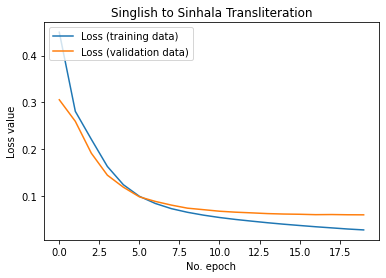

In [ ]:
history = model.fit(
    [encoder_input_data[:training_limit], decoder_input_data[:training_limit]],
    decoder_target_data[:training_limit],
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback]
)

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Singlish to Sinhala Transliteration')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig('model_plot.png')

model.save(model_id)


In [ ]:
model = keras.models.load_model(model_id)

encoder_inputs = model.input[0]  # input_1
encoder_outputs, forward_h, forward_c, backward_h, backward_c = model.layers[1].output  # lstm_1
state_h_enc = Concatenate()([forward_h, backward_h])
state_c_enc = Concatenate()([forward_c, backward_c])
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim*2,))
decoder_state_input_c = keras.Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["<S>"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]

        if sampled_char == "<E>" or len(decoded_sentence) > max_decoder_seq_length:
          stop_condition = True
        else:
          decoded_sentence += sampled_char
          decoded_sentence += " "

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [ ]:
unseen_file = open("unseen_data.txt", "w")
unseen_data_candidate = []
i = 0
for seq_index in range(num_samples-test_count,num_samples):
    i+=1
    
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    # print(input_seq.shape)
    decoded_sentence = decode_sequence(input_seq)
    unseen_file.write("-\n")
    input_sentence = input_texts[seq_index]

    unseen_data_candidate.append(decoded_sentence)

    input_sentence = input_sentence.replace(" ","")
    input_sentence = input_sentence.replace("$"," ")

    unseen_file.write(input_sentence+"\n")
    unseen_file.write(decoded_sentence+"\n")

    print(input_sentence)
    print(decoded_sentence)

df_unseen_candidate = pd.DataFrame(unseen_data_candidate)
df_unseen_candidate.to_csv (r'unseen_candidate.csv', index = False, header=False)
unseen_file.close()

nambuwa 
නෑ $ 
nathi 
නෑ $ 
karala 
නෑ $ 
yanne 
නෑ $ 
naththan 
නෑ $ 
na 
නෑ $ 
naa 
නෑ $ 
hadamuu 
නෑ $ 
oo 
නෑ $ 
ek 
නෑ $ 
aththa 
නෑ $ 
pizza 
නෑ $ 
places 
නෑ $ 
walath 
නෑ $ 
kegahanns 
නෑ $ 
puluwan 
නෑ $ 
oyaa 
නෑ $ 
damma 
නෑ $ 
companies 
නෑ $ 
walin 
නෑ $ 
calls 
නෑ $ 
awith 
නෑ $ 
da 
නෑ $ 
teams 
නෑ $ 
hodaine 
නෑ $ 
kann 
නෑ $ 
knna 
නෑ $ 
hodata 
නෑ $ 
gripe 
නෑ $ 
water 
නෑ $ 
apuu 
නෑ $ 
kmk 
නෑ $ 
na 
නෑ $ 
metana 
නෑ $ 
idan 
නෑ $ 
inn 
නෑ $ 
plwn 
නෑ $ 
results 
නෑ $ 
thama 
නෑ $ 
awe 
නෑ $ 
nah 
නෑ $ 
ne 
නෑ $ 
math 
නෑ $ 
eka 
නෑ $ 
dala 
නෑ $ 
thiyennee 
නෑ $ 
odettes+ 
නෑ $ 
vinu 
නෑ $ 
#error! 
නෑ $ 
thawa 
නෑ $ 
ekkenek 
නෑ $ 
puluwann 
නෑ $ 
ehnm 
නෑ $ 
mnwada 
නෑ $ 
kre 
නෑ $ 
anika 
නෑ $ 
lnga 
නෑ $ 
kadawal 
නෑ $ 
ith 
නෑ $ 
rhiynwalu 
නෑ $ 
suranie 
නෑ $ 
already 
නෑ $ 
invite 
නෑ $ 
kalane 
නෑ $ 
ehe 
නෑ $ 
yan 
නෑ $ 
ane 
නෑ $ 
mnda 
නෑ $ 
ane 
නෑ $ 
wenadatanm 
නෑ $ 
kianawa 
නෑ $ 
ehema 
නෑ $ 
limit 
නෑ $ 
ekk 
නෑ $ 
inna 
නෑ $ 
ennaan 
නෑ $ 
wedding

ValueError: ignored

In [ ]:
seen_file = open("seen_data.txt", "w")
seen_data_target = []
seen_data_candidate = []
i=0
for seq_index in range(min(2000,num_samples - test_count)):
    i+=1
    print("seen data ",i)
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    # print(input_seq)
    decoded_sentence = decode_sequence(input_seq)
    input_sentence = input_texts[seq_index]
    target_sentence = target_texts[seq_index]
    target_sentence = target_sentence.replace("<S>", "")
    target_sentence = target_sentence.replace("<E>", "")

    seen_data_target.append(target_sentence)
    seen_data_candidate.append(decoded_sentence)

    input_sentence = input_sentence.replace(" ","")
    input_sentence = input_sentence.replace("$"," ")

    seen_file.write("-\n")
    seen_file.write(input_sentence + "\n")
    seen_file.write(target_sentence + "\n")
    seen_file.write(decoded_sentence + "\n")

df_seen_target = pd.DataFrame(seen_data_target)
df_seen_candidate = pd.DataFrame(seen_data_candidate)
df_seen_target.to_csv (r'seen_target.csv', index = False, header=False)
df_seen_candidate.to_csv (r'seen_candidate.csv', index = False, header=False)
seen_file.close()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(unseen_data_target, unseen_data_candidate)
print(score)

In [ ]:
def removeUnnecessaryRepeats(word):
  prev = word[0]
  repeatCount = 1
  ans = word[0]
  for i in range(1,len(word)):
    if(word[i]==prev):
      repeatCount+=1
    else:
      repeatCount=1
    
    if(repeatCount<3):
      ans+=word[i]
      prev = word[i]

  return ans

In [ ]:
def preProcessSinglish(singText):
  vowels =  ['a','e','i','o','u']
  specialConsonentSuffix = ['h']
  singText = singText.lower()
  singWords = singText.split()
  finList = []
  for singWord in singWords:
    singWord = removeUnnecessaryRepeats(singWord)
    buf = ""
    for i in range(len(singWord)):
      char = singWord[i]

      if(char in vowels):
        if(i<len(singWord)-1):
          if(char == singWord[i+1]):
            buf+=char
          else:
            buf+=char
            finList.append(buf)
            buf=""
        else:
          buf+=char
          finList.append(buf)
          buf=""
      else:
        if(i<len(singWord)-1):
          if(char == singWord[i+1] or (singWord[i+1] not in vowels and singWord[i+1] not in specialConsonentSuffix)):
            buf+=char
            finList.append(buf)
            buf=""
          else:
            buf+=char
        else:
          buf+=char
          finList.append(buf)
          buf=""
    finList.append("$")

  return " ".join(finList)

In [ ]:
preProcessSinglish("aakaaarura")